In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.427491 -0.010401 -0.145090 -0.006361 -0.219625  0.147202  0.230150   
  1  -0.009905 -0.757309 -0.186438  1.104053  0.194201  0.568405 -0.367093   
  2   1.135203 -0.165090 -0.344654 -0.142659  0.269498  1.154150  0.133523   
  3   0.634733 -1.341702  0.881434 -0.004426  0.043263  0.143991  0.917870   
  4   0.282748  0.521905 -0.138555 -0.086208 -0.310155  0.893872  0.113539   
  5   0.254998 -0.294698  0.250666 -0.796555 -0.379493  0.033972  0.490579   
  6   0.546052 -0.556711 -0.351772  0.416033 -0.139121  0.533170  0.121312   
  7  -0.420004  0.133822 -0.528373  0.590486  0.457340  0.504292  0.519455   
  8   1.235607 -0.454134 -0.671558  0.034923  0.379542  0.465840 -1.033029   
  9   0.458637 -0.091583 -0.233168 -0.157795 -0.294689 -0.084640 -0.610867   
  10  1.718695 -0.238257 -0.795544  0.248970 -0.388011  0.963545  0.734200   
  11  0.865012  0.060425  0.261190 -0.366751 -0.051442  0.580011  0.090786   
  12  1.108650 -0.043720  0.435644  0.372840  0.179276  0.614402  0.099737   
  13  1.312719 -0.003509  0.010743  0.144642  0.043421  0.322838  0.763453   
  14  0.723456  0.428303  0.454714  0.020250  0.026416  0.911197 -0.009620   
  15  0.449787  0.589299  0.663606  0.950099 -0.346683  0.615594  0.177510   
  16  0.620874 -0.334099 -0.320453  0.361624  0.293520  0.466314 -0.933610   
  17 -0.532730 -0.899262 -0.758142  0.053293 -0.291341  0.441261 -0.016335   
  18  0.778243  0.227756  0.164824  1.012681  0.274176  0.108324 -0.073551   
  19  0.550237 -0.276194 -0.351297  0.587161  0.373894  0.281743  0.405656   
  20 -0.207485 -0.241390 -0.913639  0.224452  0.635705 -0.578165 -0.252723   
  21  0.525207 -0.095493 -0.713307 -0.327741  0.245305 -0.497006 -0.428177   
  22 -0.018897  0.133504  0.189957  1.012379  1.192700  0.447149  0.051920   
  23  0.291983  0.004721 -0.318288 -0.095412 -0.024403  1.076845 -0.210377   
  24 -0.001515 -0.772178  0.450534  0.209121 -0.736236  0.532302 -0.140098   
1 0   0.415741  0.323549  0.492883  0.108290 -1.154672 -0.443216 -0.179941   
  1  -0.169210 -0.242926 -0.150712 -0.704936 -0.066602 -0.584856  0.539682   
  2   0.709869  0.121094 -0.526522 -0.366542  0.858674  0.754005 -0.896860   
  3   0.686380 -0.018071  0.225196  0.755621  0.343912  0.488773  0.209794   
  4   0.292299  0.111749 -0.423386 -0.151896 -0.946455 -0.380348  0.136339   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.391579  0.108806  0.841290  ...  0.883634  0.159055 -0.618090   
  1  -1.264660 -0.189824  1.187195  ...  0.116649  0.437246 -0.030982   
  2  -0.671597 -0.760380 -0.415578  ... -0.022530 -0.654582 -0.852385   
  3   0.677630 -0.818832  0.071933  ...  1.073739 -0.201956 -1.113847   
  4  -0.616204 -0.318201 -0.206005  ... -0.252591 -0.764347 -0.934146   
  5   0.266440 -0.557398 -0.930326  ... -0.188392 -0.756656 -0.278015   
  6   0.378486  0.437513  0.096665  ... -0.378936 -0.773005 -0.605848   
  7   1.745909  1.098888  0.757620  ... -0.611992 -0.414847 -1.551016   
  8   1.195033  0.131376  0.051208  ...  0.269248 -0.529674 -0.579525   
  9  -0.523040 -1.957827  0.234470  ... -0.501232 -0.759353 -1.689639   
  10  0.065468  0.156761 -1.128869  ...  0.393297 -1.879974 -0.573607   
  11  0.968696  0.678268 -0.314281  ...  0.101242 -0.698555 -1.255950   
  12  0.506331  0.438899 -0.203879  ... -0.574906 -1.821632 -1.618350   
  13  0.274606 -0.240998  0.911635  ...  0.596965  0.233475 -0.911648   
  14 -0.027107 -1.467271 -1.314641  ...  0.537138 -0.181427 -0.575684   
  15  0.360607 -0.252339  0.087713  ... -0.150580  0.079676  1.230841   
  16  0.655119  0.160898  0.174761  ...  0.276543 -0.231150 -0.259098   
  17 -0.035279 -1.195830  0.547512  ...  0.498843 -0.177040 -0.952056   
  18  0.764068  0.509226 -0.124385  ...  0.082778 -0.433203 -0.045630   
  19 -0.454804 -1.087432 -0.355739  ... -0.502310  0.166643 -0.891794   
  20 -0.804743 -0.119298 -0.204011  ...  0.323862 -0.232941 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef  std err          t          P>|t|     2.5 %    97.5 %
D  0.941833  0.03789  24.856804  2.182984e-136  0.867569  1.016096


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



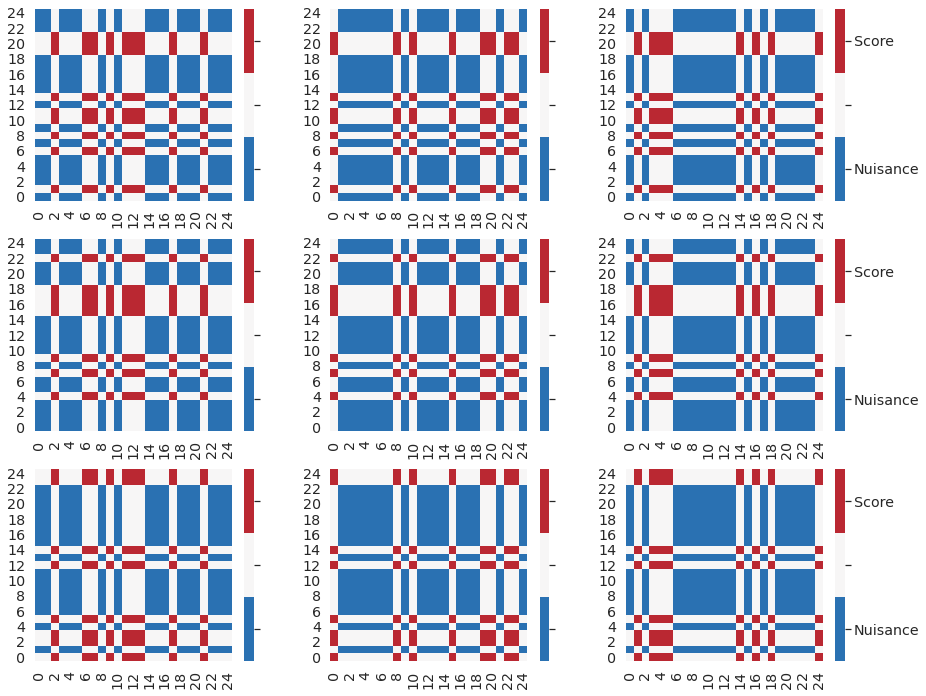

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



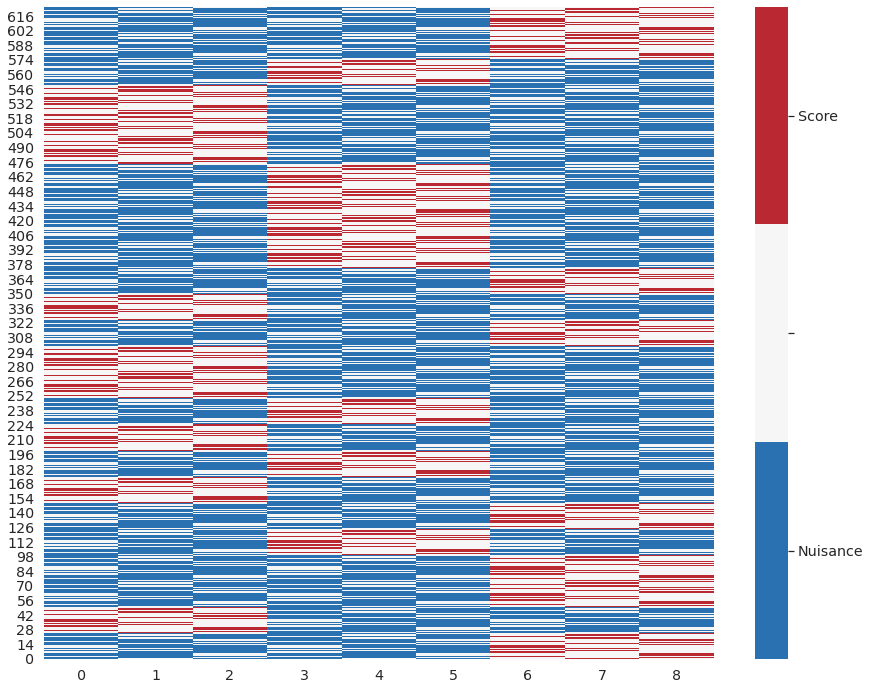

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])